In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from fuzzywuzzy import process
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt


c:\Users\alexf\AppData\Local\Programs\Python\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Clean the health diseases dataset

In [2]:
df = pd.read_csv("PLACES_Local_Data_for_Better_Health_County_Data_2022_release_20250320.csv")

df = df[df["Data_Value_Type"].str.contains("Crude", na=False)]


# Rename the city column
df = df.rename(columns={"LocationName": "city"})


# Drop unnecessary columns
df = df.drop(['StateAbbr', 'StateDesc', 'DataSource', 'Category', 'LocationID', 'CategoryID', 'DataValueTypeID', 'Geolocation', 'TotalPopulation', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Data_Value_Footnote_Symbol', 'MeasureId', 'Data_Value_Footnote' ], axis=1)
# First, let's identify the unique cities and measures
unique_cities = df['city'].unique()
unique_measures = df['Short_Question_Text'].unique()

print(f"Number of unique cities: {len(unique_cities)}")
print(f"Number of unique measures: {len(unique_measures)}")

# Create a pivot table with cities as index and measures as columns
new_df = df.pivot_table(
    index='city',
    columns='Measure',
    values='Data_Value',
    aggfunc='mean'  # Use mean if there are duplicate entries
)

# Reset the index to make 'city' a column again
new_df = new_df.reset_index()

new_df = new_df.drop(['Current lack of health insurance among adults aged 18-64 years',
'Cervical cancer screening among adult women aged 21-65 years',
'Visits to dentist or dental clinic among adults aged >=18 years',
 'Visits to doctor for routine checkup within the past year among adults aged >=18 years',
 'Mammography use among women aged 50-74 years',
 'Cholesterol screening among adults aged >=18 years',
 'Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',
 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
 'Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',
], axis=1)

# All diseases
# list(df['Measure'].unique())


df.head()



Number of unique cities: 1841
Number of unique measures: 30


,Year,city,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Short_Question_Text
0,2020,NaN,Current lack of health insurance among adults ...,%,Crude prevalence,15.3,Health Insurance
1,2020,Talladega,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,15.1,Diabetes
2,2020,Tallapoosa,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,16.0,Diabetes
4,2020,Aleutians East,Cervical cancer screening among adult women ag...,%,Crude prevalence,68.3,Cervical Cancer Screening
5,2020,Anchorage,Depression among adults aged >=18 years,%,Crude prevalence,16.5,Depression


### Clean the air quality dataset (the old one with a lot of NaNs)

In [4]:
airdf = pd.read_excel("who_ambient_air_quality_database_version_2024_(v6.1).xlsx", sheet_name="Update 2024 (V6.1)")


# Filter by US
airdf = airdf[airdf["country_name"] == "United States of America"]

# Drop unnnecessary columns
airdf = airdf.drop(['country_name', 'version','reference','web_link', 'population_source','who_ms', 'type_of_stations', 'population', 'latitude', 'longitude', 'iso3', 'who_region', 'pm25_tempcov', 'pm10_tempcov','no2_tempcov'], axis=1)

# Remove state from city names
airdf['city'] = airdf['city'].str.split(' ').str[0]

# Leave only year 2020
airdf = airdf[airdf['year'] == 2019.0]


### Import and clean new air quality dataset

In [8]:
airdf = pd.read_excel("air_quality_data_edited.xlsx")


airdf = airdf.drop(airdf.columns[0], axis=1)
airdf = airdf.rename(columns={'Core Based Statistical Area': 'city'})
airdf = airdf.iloc[:1018][['city', 'Pollutant', 2020]]

airdf['city'] = airdf['city'].fillna(method='ffill')

airdf = airdf.pivot_table(
    index='city',
    columns='Pollutant',
    values=2020,
    aggfunc='first'
)

airdf = airdf.reset_index()
airdf['city'] = airdf['city'].str.split(', ').str[0]

airdf

C:\Users\alexf\AppData\Local\Temp\ipykernel_4464\3660088022.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  airdf['city'] = airdf['city'].fillna(method='ffill')


Pollutant,city,CO,NO2,O3,PM10,PM2.5,Pb,SO2
0,Adrian,NaN,NaN,0.067,NaN,NaN,NaN,NaN
1,Akron,NaN,NaN,0.063,NaN,7.9,NaN,4.0
2,Albany,NaN,NaN,NaN,NaN,8.9,NaN,NaN
3,Albany-Schenectady-Troy,NaN,NaN,0.054,NaN,7.4,NaN,2.0
4,Albuquerque,0.9,8.0,0.071,208.0,5.4,NaN,NaN
...,...,...,...,...,...,...,...,...
336,Worcester,NaN,NaN,0.063,NaN,NaN,NaN,NaN
337,Yakima,NaN,NaN,NaN,NaN,12.3,NaN,NaN
338,York-Hanover,NaN,7.0,0.056,NaN,8.0,NaN,6.0
339,Youngstown-Warren-Boardman,NaN,NaN,0.062,22.5,6.3,NaN,NaN


In [ ]:
def find_best_match_city(city, citylist, threshold=80):
    best_match, score = process.extractOne(city, citylist)
    if score >= threshold:
        return best_match
    else: city

airdf['city'] = airdf['city'].apply(lambda x: find_best_match_city(x, unique_cities))

### Merge the dataframes

In [9]:
merged_df = pd.merge(new_df, airdf, on='city', how='inner')
merged_df = merged_df.drop_duplicates(subset='city', keep='first')
merged_df

,city,All teeth lost among adults aged >=65 years,Arthritis among adults aged >=18 years,Binge drinking among adults aged >=18 years,Cancer (excluding skin cancer) among adults aged >=18 years,Chronic kidney disease among adults aged >=18 years,Chronic obstructive pulmonary disease among adults aged >=18 years,Coronary heart disease among adults aged >=18 years,Current asthma among adults aged >=18 years,Current smoking among adults aged >=18 years,...,Sleeping less than 7 hours among adults aged >=18 years,Stroke among adults aged >=18 years,Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure,CO,NO2,O3,PM10,PM2.5,Pb,SO2
0,Albany,9.350000,19.400000,18.75,5.850000,2.500000,5.350000,5.150000,10.100000,13.35,...,30.600000,2.400000,72.350000,NaN,NaN,NaN,NaN,8.9,NaN,NaN
1,Anchorage,9.500000,20.300000,20.00,5.700000,2.400000,4.600000,4.900000,9.200000,15.70,...,30.900000,2.500000,64.000000,3.0,NaN,NaN,NaN,5.3,NaN,NaN
2,Ashtabula,17.000000,32.800000,15.20,7.800000,3.900000,12.700000,10.100000,10.800000,26.00,...,38.000000,4.500000,78.700000,NaN,NaN,0.061,NaN,NaN,NaN,6.0
3,Athens,14.700000,26.000000,18.00,5.600000,2.900000,9.300000,7.000000,11.600000,23.00,...,35.800000,3.100000,71.600000,NaN,NaN,NaN,NaN,6.1,NaN,NaN
4,Bennington,11.000000,29.100000,16.40,8.700000,3.200000,7.600000,7.700000,10.100000,14.00,...,31.000000,3.400000,78.300000,NaN,NaN,0.053,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Warren,12.992857,29.671429,15.30,7.507143,3.414286,8.542857,7.921429,10.021429,18.80,...,33.785714,3.807143,78.861538,NaN,NaN,NaN,NaN,NaN,NaN,47.0
70,Wichita,11.500000,25.300000,16.95,6.950000,3.250000,7.150000,7.500000,9.200000,16.95,...,33.450000,3.350000,75.300000,NaN,5.0,0.059,95.0,7.4,NaN,3.0
71,Winchester,10.400000,26.900000,15.40,6.700000,3.100000,7.200000,6.600000,9.600000,16.70,...,34.700000,3.300000,75.700000,NaN,NaN,0.052,NaN,NaN,NaN,NaN
72,Worcester,9.400000,29.750000,14.55,8.250000,3.200000,6.900000,7.350000,9.950000,14.35,...,30.800000,3.300000,78.100000,NaN,NaN,0.063,NaN,NaN,NaN,NaN


In [ ]:
# Print all column names to identify the correct ones
print("Merged dataframe columns:", merged_df.columns.tolist())

# Update these with the ACTUAL column names from your print output
pollutants = ['CO',	'NO2',	'O3',	'PM10',	'PM2.5',	'Pb',	'SO2']  # Use the correct names

# Get disease columns
disease_columns = [col for col in new_df.columns if col != 'city']

# Create a correlation matrix between pollutants and diseases
correlation_matrix = merged_df[pollutants + disease_columns].corr()

# Extract and transpose the correlation matrix - diseases as rows and pollutants as columns
disease_pollutant_corr = correlation_matrix.loc[disease_columns, pollutants]

# Display the correlation matrix
print("Correlation between health measures and air pollutants:")
disease_pollutant_corr

# Visualize the correlation matrix as a heatmap using matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 14))  # Adjusted for more rows than columns
im = plt.imshow(disease_pollutant_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

# Add labels and title
plt.title('Correlation between Health Measures and Air Pollutants')
plt.xticks(np.arange(len(pollutants)), pollutants, rotation=45)
plt.yticks(np.arange(len(disease_columns)), disease_columns)

# Add correlation values as text annotations
for i in range(len(disease_columns)):
    for j in range(len(pollutants)):
        text = plt.text(j, i, f'{disease_pollutant_corr.iloc[i, j]:.2f}', ha="center", va="center", color="black")

plt.tight_layout()
plt.savefig('corr.png')
plt.show()

Merged dataframe columns: ['city', 'All teeth lost among adults aged >=65 years', 'Arthritis among adults aged >=18 years', 'Binge drinking among adults aged >=18 years', 'Cancer (excluding skin cancer) among adults aged >=18 years', 'Chronic kidney disease among adults aged >=18 years', 'Chronic obstructive pulmonary disease among adults aged >=18 years', 'Coronary heart disease among adults aged >=18 years', 'Current asthma among adults aged >=18 years', 'Current smoking among adults aged >=18 years', 'Depression among adults aged >=18 years', 'Diagnosed diabetes among adults aged >=18 years', 'Fair or poor self-rated health status among adults aged >=18 years', 'High blood pressure among adults aged >=18 years', 'High cholesterol among adults aged >=18 years who have been screened in the past 5 years', 'Mental health not good for >=14 days among adults aged >=18 years', 'No leisure-time physical activity among adults aged >=18 years', 'Obesity among adults aged >=18 years', 'Physica

KeyError: "['pm10_concentration', 'pm25_concentration', 'no2_concentration'] not in index"

In [8]:
#This puts merged df into an array to use Scipy

array = merged_df.to_numpy()

print(array)
print(array.shape)

array[6,14]


[['Albany' 9.35 19.4 ... nan 9.3 nan]
 ['Aleutians East' 16.9 18.0 ... nan 5.7 nan]
 ['Alexandria' 6.2 19.5 ... nan 7.5 nan]
 ...
 ['Young' 12.9 28.5 ... 13.0 7.9 nan]
 ['Yuba' 11.7 23.2 ... nan 8.4 12.2]
 ['Yuma' 12.7 25.549999999999997 ... 35.0 7.9 nan]]
(188, 26)


27.5

In [9]:
#This is a test correlation for one disease 



X1=array[:,14]
Y=array[:,23]

x = X1.astype(float)
y = Y.astype(float)

mask = ~np.isnan(y)& ~np.isnan(x)

Y_filtered=y[mask]
X1_filtered=x[mask]

res = stats.pearsonr(X1_filtered, Y_filtered)

res

PearsonRResult(statistic=np.float64(-0.22307941609157514), pvalue=np.float64(0.03256052681131933))

In [10]:
air_pollution_parameter = [23,24,25]
disease_range_start = 1
disease_range_end = 21

permutation_model=stats.PermutationMethod(n_resamples=99999, batch=None, random_state=None, rng=None)

# Ensure Corr array matches the range
Corr = np.zeros((disease_range_end - disease_range_start + 1,len(air_pollution_parameter)))

#This computes p-values of pearson correlation test statistic between diseases and different air pollutants and puts it into a 21x3 array
for j in range(0,len(air_pollution_parameter)):
    y = array[:, air_pollution_parameter[j]]

    for i in range(disease_range_start, disease_range_end + 1):
        try:
            # Extract disease column
            a = array[:, i]
            
            # Convert to float as datasets are super messy
            a_float = a.astype(float)
            y_float = y.astype(float)
            
            # Create mask for non-NaN values in BOTH columns
            mask =  ~np.isnan(y_float) & ~np.isnan(a_float) 
            
            # Filter both arrays
            y_filtered = y_float[mask]
            a_filtered = a_float[mask]
            
            # Compute Pearson correlation
            res = stats.pearsonr(a_filtered, y_filtered,method=permutation_model)
            
            Corr[i - disease_range_start,j] = res.pvalue
            
        except Exception as e:
            print(f"Error processing column {i}: {e}")

Corr

array([[4.8712e-01, 2.2860e-02, 9.1800e-03],
       [9.0800e-03, 7.4412e-01, 4.0000e-05],
       [2.2992e-01, 9.1514e-01, 4.7984e-01],
       [6.2200e-03, 2.8680e-02, 5.0200e-03],
       [9.8728e-01, 7.5888e-01, 3.4200e-03],
       [3.2120e-01, 2.7832e-01, 1.6000e-04],
       [3.2142e-01, 9.8848e-01, 3.4000e-04],
       [8.5848e-01, 1.7242e-01, 9.4854e-01],
       [1.8178e-01, 2.1028e-01, 9.2000e-04],
       [2.7682e-01, 1.8280e-02, 1.7190e-01],
       [9.3480e-01, 4.5474e-01, 4.0200e-03],
       [5.3980e-02, 4.0200e-03, 2.1820e-02],
       [1.5660e-02, 6.6650e-01, 2.7200e-03],
       [3.5140e-02, 7.3660e-01, 1.0800e-03],
       [1.4272e-01, 1.0000e-04, 1.8182e-01],
       [7.6182e-01, 5.9540e-02, 5.0600e-03],
       [6.7838e-01, 9.2820e-02, 2.5400e-03],
       [1.8386e-01, 3.5480e-02, 3.5600e-03],
       [1.9414e-01, 6.5580e-02, 1.5560e-02],
       [5.6452e-01, 6.8398e-01, 4.3000e-03],
       [3.6000e-04, 1.2016e-01, 8.2000e-04]])

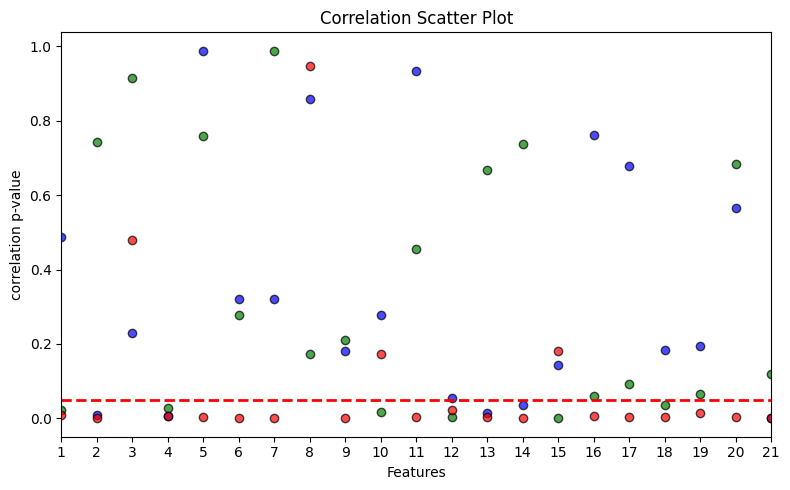

Length of Corr: 21
Length of features: 21


In [11]:
#This creates a scatter plot of diseases and thier p-values

features = np.arange(1, len(Corr) + 1)



plt.figure(figsize=(8,5))
plt.scatter(features, Corr[:,0], color='blue', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr[:,1], color='green', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr[:,2], color='red', edgecolors='black', alpha=0.7)
# Red line at y=0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2)

plt.xlim(1, len(Corr))

plt.xticks(features)

plt.xlabel('Features')
plt.ylabel('correlation p-value')
plt.title('Correlation Scatter Plot')

plt.tight_layout()
plt.show()

# Verify lengths
print("Length of Corr:", len(Corr))
print("Length of features:", len(features))

(21, 3)
[[      nan 2.286e-02 9.180e-03]
 [9.080e-03       nan 4.000e-05]
 [      nan       nan       nan]
 [6.220e-03 2.868e-02 5.020e-03]
 [      nan       nan 3.420e-03]
 [      nan       nan 1.600e-04]
 [      nan       nan 3.400e-04]
 [      nan       nan       nan]
 [      nan       nan 9.200e-04]
 [      nan 1.828e-02       nan]
 [      nan       nan 4.020e-03]
 [      nan 4.020e-03 2.182e-02]
 [1.566e-02       nan 2.720e-03]
 [3.514e-02       nan 1.080e-03]
 [      nan 1.000e-04       nan]
 [      nan       nan 5.060e-03]
 [      nan       nan 2.540e-03]
 [      nan 3.548e-02 3.560e-03]
 [      nan       nan 1.556e-02]
 [      nan       nan 4.300e-03]
 [3.600e-04       nan 8.200e-04]]


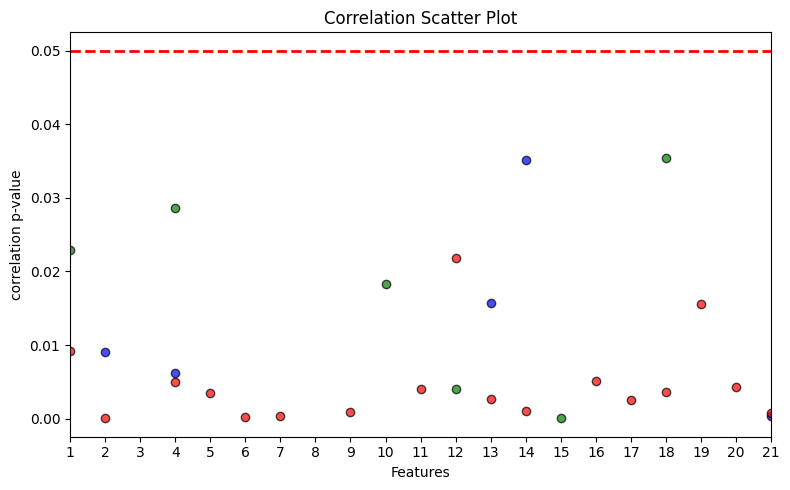

Length of Corr_significant: 21
Length of features: 21


In [12]:
#This filters the Corr matrix so that only statistically significant values (p<=0.05) remain
print(Corr.shape)

Corr_significat=Corr.copy() #if I dont use copy(), Corr also changes when I change Corr_significant
Corr_significat[Corr_significat > 0.05] = np.nan
print(Corr_significat)

#This creates a scatter plot with statistically significant values

features = np.arange(1, len(Corr_significat) + 1)

plt.figure(figsize=(8,5))
plt.scatter(features, Corr_significat[:,0], color='blue', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_significat[:,1], color='green', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_significat[:,2], color='red', edgecolors='black', alpha=0.7)
# Red line at y=0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2)

plt.xlim(1, len(Corr))

plt.xticks(features)

plt.xlabel('Features')
plt.ylabel('correlation p-value')
plt.title('Correlation Scatter Plot')

plt.tight_layout()
plt.show()

# Verify lengths
print("Length of Corr_significant:", len(Corr_significat))
print("Length of features:", len(features))

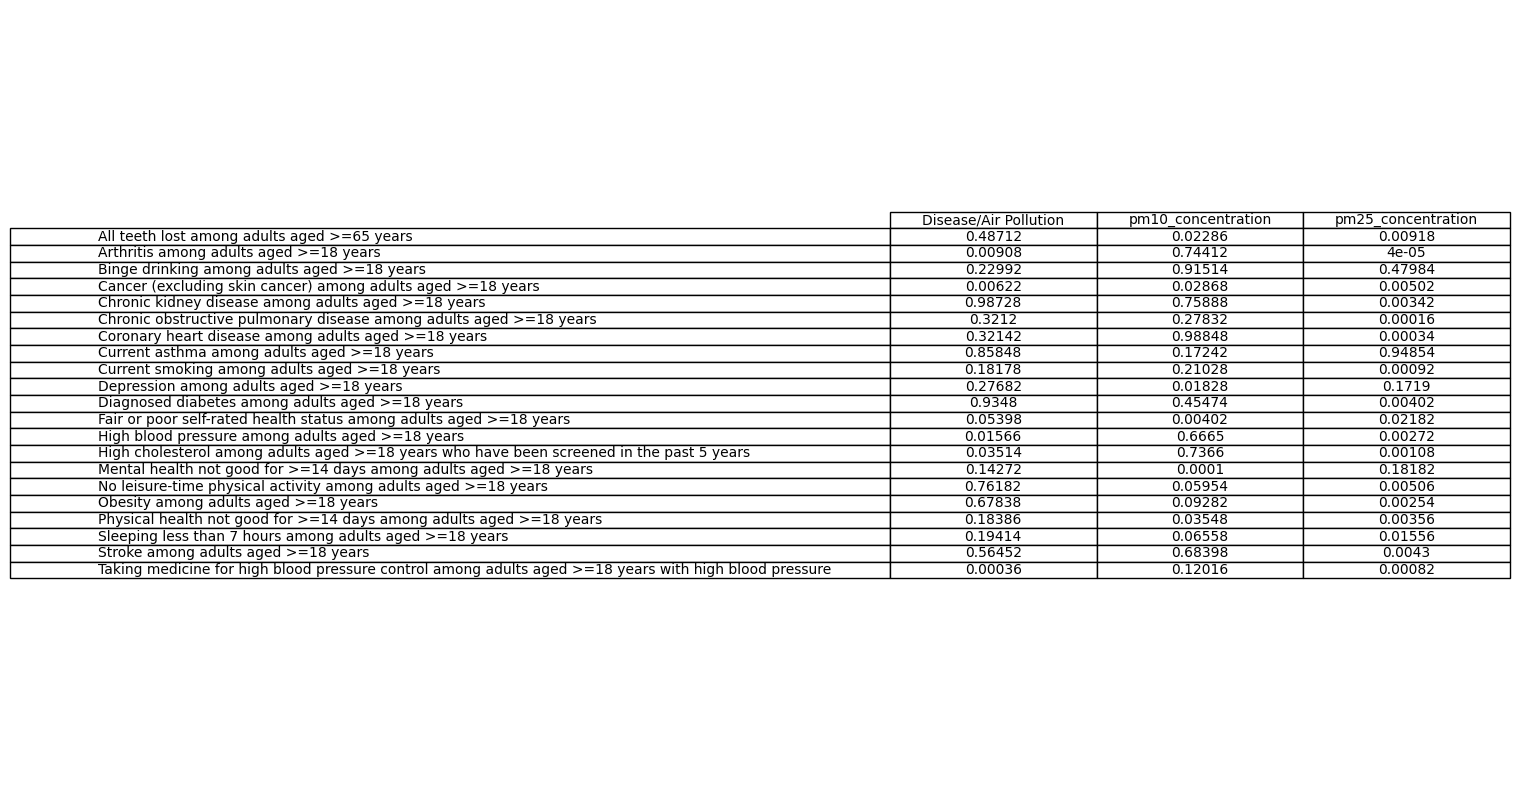

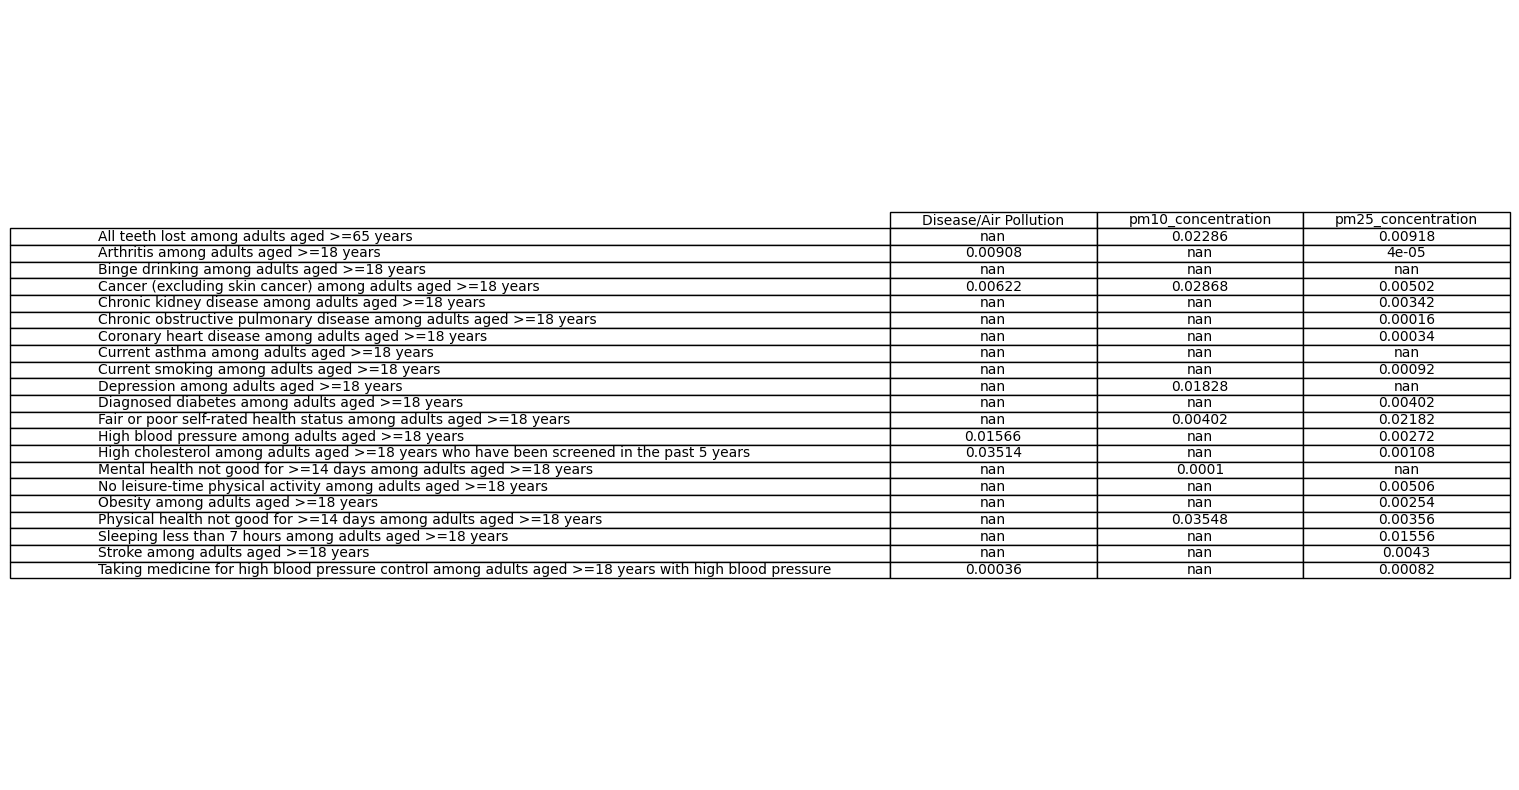

In [13]:
correlation_df= pd.DataFrame(Corr, index=disease_columns, columns=pollutants)

significant_correlation_df = correlation_df.where(correlation_df <= 0.05, np.nan)

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=correlation_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=correlation_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=significant_correlation_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=significant_correlation_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()
